In [1]:
'''!pip install aicrowd-cli
API_KEY = "9967b67c796b4d50e5d26f4dfd97ed06" 
!aicrowd login --api-key $API_KEY
!aicrowd dataset download --challenge global-wheat-challenge-2021'''

'!pip install aicrowd-cli\nAPI_KEY = "9967b67c796b4d50e5d26f4dfd97ed06" \n!aicrowd login --api-key $API_KEY\n!aicrowd dataset download --challenge global-wheat-challenge-2021'

In [2]:
'''import shutil
shutil.copyfile('/content/train.zip',
                '/content/drive/MyDrive/aicrowd_wheat/train.zip')
shutil.copyfile('/content/test.zip',
                '/content/drive/MyDrive/aicrowd_wheat/test.zip')
shutil.copyfile('/content/submission.csv',
                '/content/drive/MyDrive/aicrowd_wheat/submission.csv')'''

"import shutil\nshutil.copyfile('/content/train.zip',\n                '/content/drive/MyDrive/aicrowd_wheat/train.zip')\nshutil.copyfile('/content/test.zip',\n                '/content/drive/MyDrive/aicrowd_wheat/test.zip')\nshutil.copyfile('/content/submission.csv',\n                '/content/drive/MyDrive/aicrowd_wheat/submission.csv')"

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun 15 03:57:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
import shutil
import pandas as pd
import numpy as np 
import os
import cv2
import re
import joblib

from matplotlib import pyplot as plt
from datetime import datetime

In [6]:
if(os.path.isdir('train')):
  print('folder exists, skip unzip procedure')
else:
  shutil.copyfile('/content/drive/MyDrive/aicrowd_wheat/train.zip','/content/train.zip')
  shutil.unpack_archive('./train.zip')
  #!unzip train.zip

folder exists, skip unzip procedure


In [7]:
len(os.listdir('./train/')), os.listdir('./train/')[0:3]

(3655,
 ['44d2e512d719f7d67bdc19e0a3eaaa3666122136b6e0c9837eaed9c0130217f8.png',
  '86780560bf43fee133956cb2c6aa5ec1f9091af49088b2602dba73c59dad65e2.png',
  '53826036c998109048e797584493b0e9628a4018d5d0a729172c08662413def7.png'])

In [8]:
df_train = pd.read_csv('./train.csv')
df_train['image_id'] = df_train['image_name']
df_train['file_name'] = df_train['image_name']+'.png'
df_train['has_boxes'] = np.where(df_train['BoxesString']=='no_box','no','yes')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657 entries, 0 to 3656
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_name   3657 non-null   object
 1   BoxesString  3657 non-null   object
 2   domain       3657 non-null   int64 
 3   image_id     3657 non-null   object
 4   file_name    3657 non-null   object
 5   has_boxes    3657 non-null   object
dtypes: int64(1), object(5)
memory usage: 171.5+ KB


In [9]:
df_train['has_boxes'].value_counts()

yes    3607
no       50
Name: has_boxes, dtype: int64

In [81]:
train_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/train_set')
test_images = joblib.load('/content/drive/MyDrive/aicrowd_wheat/test_set')
train_images.shape, test_images.shape

((2925,), (732,))

In [10]:
image_size = 512
bs = 32

In [17]:
!pip install -q -U fastai
!pip install -q -U albumentations

     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 38.2MB 1.3MB/s 


In [18]:
from fastai.data.all import *
from fastai.vision.all import *
import albumentations

In [42]:
class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def get_train_aug(): return albumentations.Compose([
            # albumentations.RandomSizedCrop(image_size, image_size),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            albumentations.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            # albumentations.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            # albumentations.Normalize(),
            #albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5),
            # ToTensorV2(p=1.0),
])

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SymmetricCrossEntropy(nn.Module):

    def __init__(self, alpha=0.1, beta=1.0, num_classes= 5):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes

    def forward(self, logits, targets, reduction='mean'):
        onehot_targets = torch.eye(self.num_classes)[targets].cuda()
        ce_loss = F.cross_entropy(logits, targets, reduction=reduction)
        rce_loss = (-onehot_targets*logits.softmax(1).clamp(1e-7, 1.0).log()).sum(1)
        if reduction == 'mean':
            rce_loss = rce_loss.mean()
        elif reduction == 'sum':
            rce_loss = rce_loss.sum()
        return self.alpha * ce_loss + self.beta * rce_loss

In [85]:
df_sel_cols = df_train[df_train.image_id.isin(train_images)][['file_name','has_boxes']]
print(df_sel_cols.shape)
df_resampled = df_sel_cols.copy(deep=True)
#df_resampled = df_sel_cols[df_sel_cols['has_boxes']=='no']\
#.append(df_sel_cols[df_sel_cols['has_boxes']=='yes'].sample(2000))
df_resampled.has_boxes.value_counts()

(2926, 2)


yes    2884
no       42
Name: has_boxes, dtype: int64

In [90]:
df_test = df_train[df_train.image_id.isin(test_images)][['file_name','has_boxes']]
df_test.has_boxes.value_counts()

yes    725
no       8
Name: has_boxes, dtype: int64

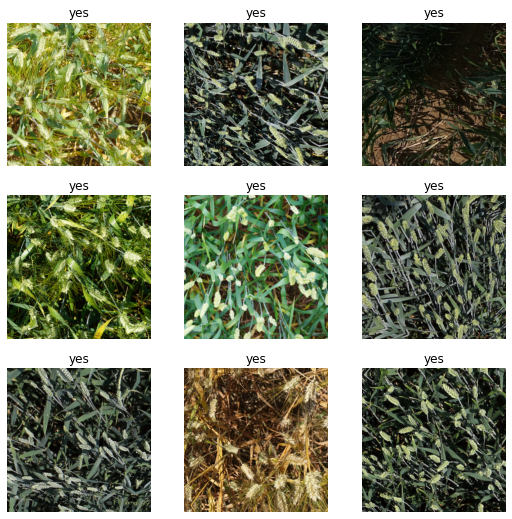

In [86]:
wheat = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader(0, pref='/content/train/'),
                   get_y=ColReader(1),
                   batch_tfms = [*aug_transforms(size=(256,256), flip_vert=True, max_rotate=75, max_zoom=1.1), 
                                 Normalize.from_stats(*imagenet_stats)],
                   splitter = RandomSplitter(0.2)
                   )
dls = wheat.dataloaders(df_resampled[['file_name','has_boxes']], bs=bs)
dls.show_batch()

In [87]:
learn = cnn_learner(dls, 
                    densenet121,
                    # resnet101,
                    metrics=[accuracy, F1Score(), Precision(), Recall()
                             # RocAucMulti, 
                             # F1ScoreMulti
                                           ])
# learn.loss_func = SymmetricCrossEntropy()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


SuggestedLRs(lr_min=0.03630780577659607, lr_steep=8.31763736641733e-06)

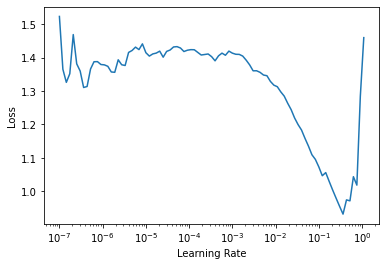

In [88]:
learn.lr_find(suggestions=True)

In [131]:
learn.fit_one_cycle(20, 
                    # lr_max=0.01
                    lr_max=slice(1e-3, 0.1)
                    )

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.057220,0.058087,0.991453,0.995671,0.991379,1.000000,01:23
1,0.091310,0.513781,0.984615,0.992235,0.984589,1.000000,01:23
2,0.375397,0.417152,0.960684,0.979700,0.994624,0.965217,01:23
3,0.572379,3.670008,0.945299,0.971429,0.998165,0.946087,01:23
4,0.527445,1.054518,0.989744,0.994783,0.994783,0.994783,01:23
5,0.719614,0.881225,0.993162,0.996522,0.996522,0.996522,01:23
6,0.959780,0.376042,0.993162,0.996534,0.993092,1.000000,01:23
7,1.060533,0.321292,0.991453,0.995641,0.998252,0.993043,01:24
8,0.807695,1.092638,0.984615,0.992235,0.984589,1.000000,01:24
9,0.582547,0.634964,0.993162,0.996534,0.993092,1.000000,01:23


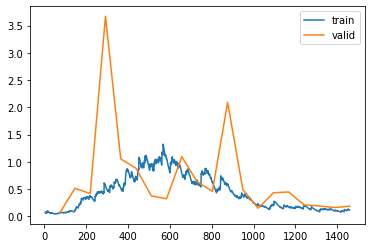

In [132]:
learn.recorder.plot_loss()

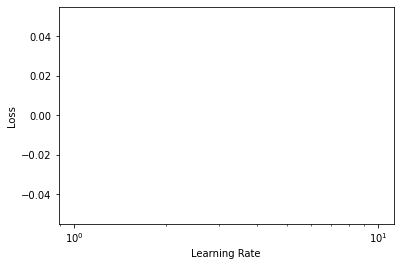

In [133]:
learn.unfreeze()
learn.lr_find(suggestions=True)

In [62]:
learn.unfreeze()
learn.fit_one_cycle(10, lr_max=5e-07)

epoch,train_loss,valid_loss,accuracy,time
0,0.173643,0.032427,0.985714,00:10
1,0.177334,0.031444,0.985714,00:10
2,0.168493,0.033028,0.985714,00:10
3,0.189109,0.036510,0.985714,00:11


KeyboardInterrupt: ignored

In [123]:
results = []
for i, row in df_test.iterrows():
  actual = row[1]
  file_name = row[0]
  pred = learn.predict('/content/train/'+file_name)
  # print(actual, file_name)
  results.append([file_name, actual, pred[0]])

In [124]:
df_results = pd.DataFrame(results, columns=['file_name','actual','prediction'])
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   733 non-null    object
 1   actual      733 non-null    object
 2   prediction  733 non-null    object
dtypes: object(3)
memory usage: 17.3+ KB


In [128]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(df_results['actual'], df_results['prediction']))

              precision    recall  f1-score   support

          no       0.33      0.62      0.43         8
         yes       1.00      0.99      0.99       725

    accuracy                           0.98       733
   macro avg       0.66      0.81      0.71       733
weighted avg       0.99      0.98      0.98       733



In [135]:
confusion_matrix(df_results['actual'], df_results['prediction']).ravel()

array([  5,   3,  10, 715])

In [126]:
''' no undersampling
              precision    recall  f1-score   support

          no       0.33      0.62      0.43         8
         yes       1.00      0.99      0.99       725

    accuracy                           0.98       733
   macro avg       0.66      0.81      0.71       733
weighted avg       0.99      0.98      0.98       733'''

'              precision    recall  f1-score   support\n\n          no       0.33      0.62      0.43         8\n         yes       1.00      0.99      0.99       725\n\n    accuracy                           0.98       733\n   macro avg       0.66      0.81      0.71       733\nweighted avg       0.99      0.98      0.98       733'

In [136]:
if(os.path.isdir('test')):
  print('folder exists, skip unzip procedure')
else:
  shutil.copyfile('/content/drive/MyDrive/aicrowd_wheat/test.zip','/content/test.zip')
  shutil.unpack_archive('./test.zip')
  #!unzip train.zip

In [144]:
test_files = os.listdir('/content/test/')
results_test = []
for file_ in test_files:
  pred = learn.predict('/content/test/'+file_)
  results_test.append([file_, pred[0]])
df_results_test = pd.DataFrame(results_test, columns=['file_name', 'prediction'])
df_results_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2856 entries, 0 to 2855
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   2856 non-null   object
 1   prediction  2856 non-null   object
dtypes: object(2)
memory usage: 44.8+ KB


In [145]:
df_results_test.prediction.value_counts()

yes    2785
no       71
Name: prediction, dtype: int64

In [146]:
df_results_test.head()

,file_name,prediction
0,ef6bb2c65550d96bfa4dbdd190016be94cca64cfe5fb669c3e16c4a53abb9757.png,yes
1,e2f3c1b20ff3ee4bdc2702b16c45d4557165cc5322adc6b34a0ea384e0038545.png,yes
2,3e94ec5cd9992c46c0908ec608e157a0173cc6bc9060a9c13648e10b8a62bfe5.png,yes
3,cba8c90d58caeacbea1be3e8497aeac13379d1a31901321f4cc06941e5cbd436.png,yes
4,ffc6c7d470006a7ab91bdf62e68fd8e95455d0f119246c042e160c63e7168f8a.png,yes


In [147]:
df_results_test.to_csv('/content/drive/MyDrive/aicrowd_wheat/binary_preds.csv', index=False)